## Compare LucasKAN's ability in function interpolation with MLP (Multi-variable)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from LucasKANLayer import LucasKANLayer

In [2]:
# Define the fractal-like 2D function
def fractal_function(x, y):
    z = np.sin(10 * np.pi * x) * np.cos(10 * np.pi * y) + np.sin(np.pi * (x**2 + y**2))
    z += np.abs(x - y) + (np.sin(5 * x * y) / (0.1 + np.abs(x + y)))
    z *= np.exp(-0.1 * (x**2 + y**2))
    
    # Add noise to z
    noise = np.random.normal(0, 0.1, z.shape)
    z += noise
    
    return z

In [3]:
# Define MLP and LucasKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        return self.layers(x)
        
# Define the LucasKAN model
class LucasKAN(nn.Module):
    def __init__(self):
        super(LucasKAN, self).__init__()
        # Instantiate layers of LucasKANLayer with the correct dimensions
        self.lucaskan1 = LucasKANLayer(2, 8, 8)
        self.lucaskan2 = LucasKANLayer(8, 16, 4)
        self.lucaskan3 = LucasKANLayer(16, 1, 4)

    def forward(self, x):
        # Ensure the outputs of one layer are inputs to the next
        x = self.lucaskan1(x)
        x = self.lucaskan2(x)
        x = self.lucaskan3(x)
        return x


Epoch 1/2000, MLP Loss: 1.1734, LucasKAN Loss: 1.1571
Epoch 101/2000, MLP Loss: 0.3475, LucasKAN Loss: 0.3805
Epoch 201/2000, MLP Loss: 0.2822, LucasKAN Loss: 0.3772
Epoch 301/2000, MLP Loss: 0.2599, LucasKAN Loss: 0.3496
Epoch 401/2000, MLP Loss: 0.2421, LucasKAN Loss: 0.3125
Epoch 501/2000, MLP Loss: 0.2227, LucasKAN Loss: 0.2951
Epoch 601/2000, MLP Loss: 0.2371, LucasKAN Loss: 0.2728
Epoch 701/2000, MLP Loss: 0.2193, LucasKAN Loss: 0.2628
Epoch 801/2000, MLP Loss: 0.3665, LucasKAN Loss: 0.2224
Epoch 901/2000, MLP Loss: 0.2261, LucasKAN Loss: 0.2190
Epoch 1001/2000, MLP Loss: 0.2887, LucasKAN Loss: 0.2771
Epoch 1101/2000, MLP Loss: 0.2055, LucasKAN Loss: 0.2007
Epoch 1201/2000, MLP Loss: 0.2024, LucasKAN Loss: 0.2201
Epoch 1301/2000, MLP Loss: 0.2005, LucasKAN Loss: 0.1976
Epoch 1401/2000, MLP Loss: 0.2043, LucasKAN Loss: 0.1961
Epoch 1501/2000, MLP Loss: 0.2009, LucasKAN Loss: 0.1995
Epoch 1601/2000, MLP Loss: 0.1990, LucasKAN Loss: 0.2032
Epoch 1701/2000, MLP Loss: 0.2066, LucasKAN

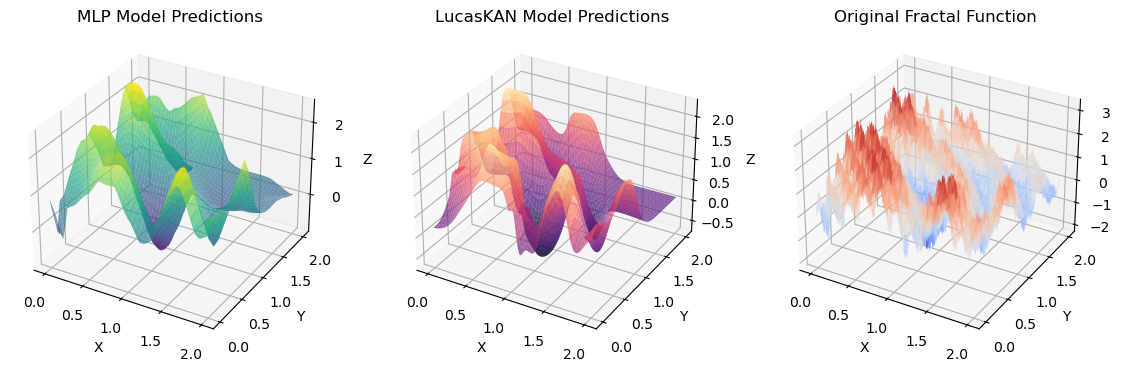

In [4]:
torch.autograd.set_detect_anomaly(True)

# Generate 2D sample data
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = fractal_function(X, Y)
x_train_2d = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)
y_train_2d = torch.tensor(Z.ravel(), dtype=torch.float32).unsqueeze(1)

# Instantiate the models
mlp_model = SimpleMLP()  
Lucas_model = LucasKAN()

# Define loss functions and optimizers
criterion = nn.MSELoss()
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.01)
optimizer_Lucas = torch.optim.Adam(Lucas_model.parameters(), lr=0.01)

# Train the models
epochs = 2000
for epoch in range(epochs):
    # MLP Training
    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train_2d)
    loss_mlp = criterion(outputs_mlp, y_train_2d)
    loss_mlp.backward()
    optimizer_mlp.step()

    # LucasKAN Training
    optimizer_Lucas.zero_grad()
    outputs_Lucas = Lucas_model(x_train_2d)
    loss_Lucas = criterion(outputs_Lucas, y_train_2d)
    loss_Lucas.backward()
    optimizer_Lucas.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, MLP Loss: {loss_mlp.item():.4f}, LucasKAN Loss: {loss_Lucas.item():.4f}')

# Test the models
x_test = np.linspace(0, 2, 400)
y_test = np.linspace(0, 2, 400)
X_test, Y_test = np.meshgrid(x_test, y_test)
Z_test = fractal_function(X_test, Y_test)
x_test_2d = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32)
y_pred_mlp = mlp_model(x_test_2d).detach().numpy()
y_pred_Lucas = Lucas_model(x_test_2d).detach().numpy()

# Plot the results using a 3D plot
fig = plt.figure(figsize=(14, 21))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X_test, Y_test, y_pred_mlp.reshape(X_test.shape), cmap='viridis', alpha=0.7, label='MLP Prediction')
ax1.set_title('MLP Model Predictions')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X_test, Y_test, y_pred_Lucas.reshape(X_test.shape), cmap='magma', alpha=0.7, label='LucasKAN Prediction')
ax2.set_title('LucasKAN Model Predictions')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X_test, Y_test, Z_test, cmap='coolwarm', alpha=0.7, label='Original Function')
ax3.set_title('Original Fractal Function')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
plt.show()